# Simulating a galaxy survey

In this exercise, we will simulate a galaxy survey for cosmic shear with a software package called [GLASS](https://glass.readthedocs.io/).
More specifically, we will create simulated maps of the cosmic matter density, and the weak lensing fields of convergence and shear.

Modern cosmological surveys cover very large parts of the sky, and so must our simulation. That means we have to work on the sphere, and not flat space. To do so, we use a pixelisation of the sphere called [HEALPix](https://en.wikipedia.org/wiki/HEALPix), which is the de facto standard format for full-sky maps in cosmology. We can use the `healpy` package to work with HEALPix maps.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

The most important fact about HEALPix is that every map has a resolution, given by the so-called $\mathtt{NSIDE}$ parameter. A HEALPix map is a simple array of $12 \, \mathtt{NSIDE}^2$ numbers, one for each pixel. And each pixel has a fixed and known position in the sky.

> What is the pixel size of a HEALPix map at a given $\mathtt{NSIDE}$ parameter? Hint: The area of the unit sphere is $\frac{60^4}{100\pi}$ deg$^2$, $\frac{60^6}{100\pi}$ arcmin$^2$, and $\frac{60^8}{100\pi}$ arcsec$^2$.

## Survey

We start by characterising the galaxy survey that we wish to simulate. Any real galaxy survey will not observe the entire sky, but only a fraction. To model this, we create a HEALPix map of the footprint of our survey.

In [2]:
# resolution of our simulation
nside = 1024

# get longitude and latitude of all HEALPix pixels
lon, lat = hp.pix2ang(nside, np.arange(12 * nside**2), lonlat=True)

# create a footprint by selecting pixels in the desired RA and Dec range
fp = (((lon > 329.5) | (lon < 53.5)) & ((-45.6 < lat) & (lat < -15.7))) * 1.0

The `healpy` package comes with a number of visualisations for HEALPix maps, which we can use to show the footprint that we generated.

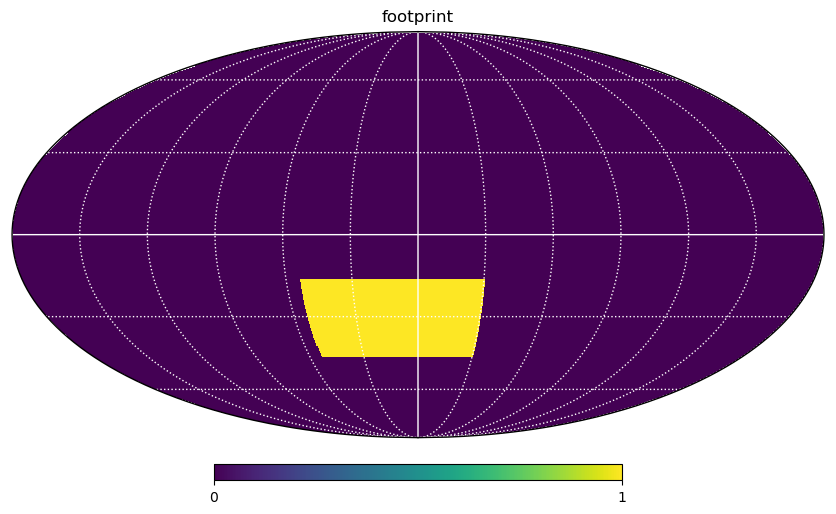

In [3]:
# show the footprint we created on the full sky
hp.mollview(fp, title="footprint")
hp.graticule(c="w")
plt.show()

> How can you calculate the fraction of the sky that this footprint covers? Hint: what is the sky fraction if half of the footprint values are 1.0, and half are 0.0?

> What is the footprint area?

We save the simulated footprint to disk for later use.

In [4]:
hp.write_map("footprint.fits.gz", fp, dtype=np.float32, fits_IDL=False, column_names=["FOOTPRINT"], overwrite=True)

Just as important as the angular selection is the radial one. That is encoded in the normalised redshift distribution $n(z)$ of the observed galaxies. Here, we use a redshift distribution that comes with GLASS.

In [5]:
from glass.observations import smail_nz

# true redshift distribution following a Smail distribution
z = np.arange(0., 3.0, 0.005)
nz = smail_nz(z, z_mode=0.9, alpha=2.0, beta=1.5)

In [6]:
# check that n(z) is normalised
np.trapz(nz, z)

1.0

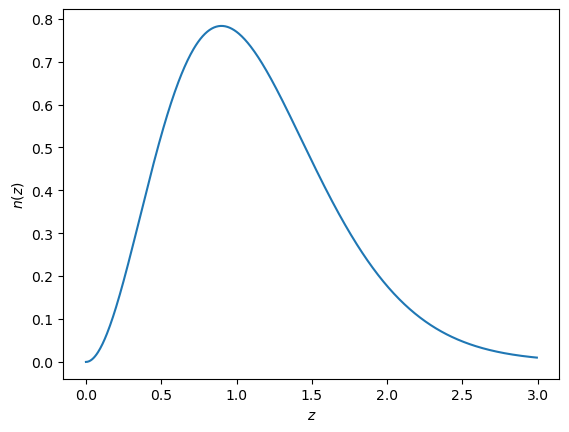

In [7]:
# plot the redshift distribution
plt.plot(z, nz)
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

A further survey characteristic is the observed galaxy density, which directly determines the noise level of the eventual cosmic shear measurements. The galaxy density is commonly quoted as galaxies per arcmin$^2$.

When simulating galaxies, GLASS works with the galaxy number distribution $dN/dz$, which is $n(z)$ scaled by the total galaxy density.

In [8]:
galaxy_density = 1.0 # galaxies/arcmin2

# galaxy number distribution
dndz = galaxy_density * nz

In [9]:
# check that dndz recovers galaxy_density
np.trapz(dndz, z)

1.0

Next, we split the redshift distribution up into a number of equi-populated tomographic bins. This will allow us to recover radial information from cosmic shear.

In [10]:
from glass.observations import equal_dens_zbins

# compute tomographic redshift bin edges with equal density
nbins = 6
zbins = equal_dens_zbins(z, dndz, nbins=nbins)

# labels to attach to the individual bins, this could be anything 
binlabels = np.arange(1, nbins + 1)

In [11]:
zbins

[(0.0, 0.6021723638505788),
 (0.6021723638505788, 0.8325437468467008),
 (0.8325437468467008, 1.047387757536588),
 (1.047387757536588, 1.2874867068781044),
 (1.2874867068781044, 1.6190632889938532),
 (1.6190632889938532, 2.995)]

We can now split the overall distribution $dN/dz$ up into the individual redshift bins. However, due to the uncertainty in photometric redshifts, the split between bins is not sharp. We can model this using a Gaussian photometric redshift error.

In [12]:
from glass.observations import tomo_nz_gausserr

# photometric redshift error at redshift zero
sigma_z0 = 0.03

# split the overall dndz up into tomographic bins with a Gaussian error
tomo_dndz = tomo_nz_gausserr(z, dndz, sigma_z0, zbins)

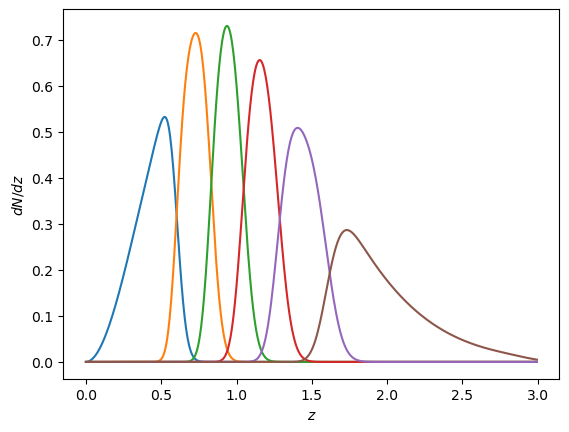

In [13]:
# plot the tomographic redshift distribution
plt.plot(z, tomo_dndz.T)
plt.xlabel("$z$")
plt.ylabel("$dN/dz$")
plt.show()

We save the tomographic redshift distribution to file, so that we can use it later.

In [14]:
np.savez("nz.npz", z=z, nz=tomo_dndz)

The final survey characteristic is the so-called "shape noise" of galaxies, which is the standard deviation of the intrinsic galaxy ellipticities, before they are sheared.

In [15]:
# ellipticity standard deviation per component
sigma_e = 0.25

Footprint, redshift distribution, galaxy density, photometric redshift erss, and shape noise — these are the quantities that characterise a cosmic shear survey.

## Cosmology

Next, we need to set up the cosmology that we wish to simulate. This will then be used by the code to compute, e.g., the cosmological distance functions.

There are many cosmological codes in use. Here, we use CAMB, which is nicely integrated with GLASS.

In [16]:
import camb
from cosmology import Cosmology

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get a cosmology object from CAMB
cosmo = Cosmology.from_camb(pars)

## Simulation

In [17]:
from glass.shells import distance_grid, tophat_windows

# shells of 200 Mpc in comoving distance spacing
zgrid = distance_grid(cosmo, 0.0, 3.0, dx=200.)

# tophat window functions for shells
shells = tophat_windows(zgrid)

In [18]:
# the angular modes we want to simulate
lmax = 2000

In [19]:
recompute = False

In [20]:
from glass.ext.camb import matter_cls
from glass.fields import lognormal_gls
from glass.user import load_cls, save_cls

if recompute:
    # compute the angular matter power spectra of the shells with CAMB
    cls = matter_cls(pars, lmax, shells)

    # compute Gaussian cls for lognormal fields for 3 correlated shells
    # putting nside here means that the HEALPix pixel window function is applied
    gls = lognormal_gls(cls, nside=nside, lmax=lmax, ncorr=3)

    # store the lognormal spectra for later
    save_cls("gls.npz", gls)
else:
    # load previously computed lognormal spectra
    gls = load_cls("gls.npz")

In [21]:
from glass.shells import partition

# compute the galaxies density for each bin in each shell
ngal = partition(z, tomo_dndz, shells)

In [22]:
# adding ngal should recover the total galaxy density
ngal.sum(), galaxy_density

(0.9994015017704014, 1.0)

## Running the simulation

In [23]:
from glass.fields import generate_lognormal
from glass.galaxies import galaxy_shear, redshifts
from glass.lensing import MultiPlaneConvergence, shear_from_convergence
from glass.points import positions_from_delta
from glass.shapes import ellipticity_intnorm
from glass.user import write_catalog

# we write the catalogue to a FITS file as it is generated
with write_catalog("catalog.fits") as out:

    # generator for lognormal matter fields
    matter = generate_lognormal(gls, nside, ncorr=3)

    # this will compute the convergence field iteratively
    convergence = MultiPlaneConvergence(cosmo)

    # simulate the matter fields in the main loop, and build up the catalogue
    for i, delta in enumerate(matter):

        print(f"shell {i}, redshift {shells[i].zeff:.3f}")

        # compute the lensing maps for this shell
        convergence.add_window(delta, shells[i])
        kappa = convergence.kappa
        gamm1, gamm2 = shear_from_convergence(kappa)
    
        # generate galaxy positions from matter density contrast and footprint
        # this goes through all galaxies in batches
        for gal_lon, gal_lat, gal_count in positions_from_delta(ngal[i], delta, None, fp):

            print(f"+ {gal_count}")

            # generate random redshifts within the shells
            gal_z = redshifts(gal_count, shells[i])
    
            # get the tomographic bin label for each galaxy
            gal_bin = np.repeat(binlabels, gal_count)
    
            # generate galaxy ellipticities from the chosen distribution
            gal_eps = ellipticity_intnorm(gal_count, sigma_e)
    
            # apply the shear fields to the ellipticities
            gal_she = galaxy_shear(gal_lon, gal_lat, gal_eps, kappa, gamm1, gamm2)
    
            # write rows for this batch of galaxies
            out.write(
                RA=gal_lon,
                DEC=gal_lat,
                E1=gal_she.real,
                E2=gal_she.imag,
                BIN=gal_bin,
                ZTRUE=gal_z,
            )

shell 0, redshift 0.024
+ [867   0   0   0   0   0]
+ [  0 150   0   0   0   0]
+ [  0   0 152   0   0   0]
+ [  0   0   0 173   0   0]
+ [  0   0   0   0 100   0]
+ [  0   0   0   0   0 123]
shell 1, redshift 0.071
+ [7566    0    0    0    0    0]
+ [  0 208   0   0   0   0]
+ [  0   0 216   0   0   0]
+ [  0   0   0 238   0   0]
+ [  0   0   0   0 145   0]
+ [  0   0   0   0   0 161]
shell 2, redshift 0.120
+ [20204     0     0     0     0     0]
+ [  0 220   0   0   0   0]
+ [  0   0 206   0   0   0]
+ [  0   0   0 284   0   0]
+ [  0   0   0   0 148   0]
+ [  0   0   0   0   0 166]
shell 3, redshift 0.170
+ [37195     0     0     0     0     0]
+ [  0 197   0   0   0   0]
+ [  0   0 258   0   0   0]
+ [  0   0   0 270   0   0]
+ [  0   0   0   0 149   0]
+ [  0   0   0   0   0 144]
shell 4, redshift 0.222
+ [60681     0     0     0     0     0]
+ [  0 205   0   0   0   0]
+ [  0   0 245   0   0   0]
+ [  0   0   0 255   0   0]
+ [  0   0   0   0 157   0]
+ [  0   0   0   0   0 159

We can load the catalogue we just wrote to check it is as we expect it to be.

In [24]:
import fitsio

# read the catalogue
cat = fitsio.read("catalog.fits")

In [25]:
# get the column names
cat.dtype.names

('RA', 'DEC', 'E1', 'E2', 'BIN', 'ZTRUE')

In [26]:
# get the catalogue size
cat.size

7693589

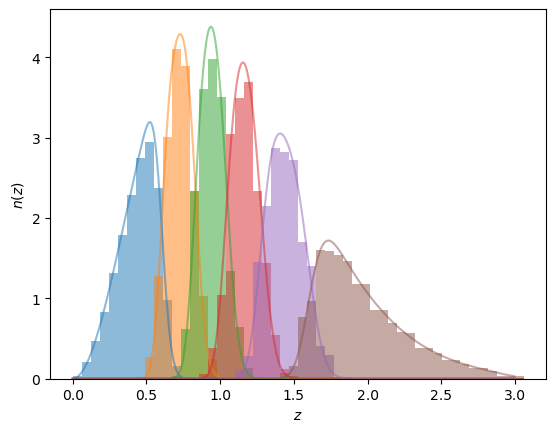

In [27]:
# check the realised redshift distribution
for i in range(nbins):
    plt.hist(
        cat["ZTRUE"][cat["BIN"] == i + 1],
        histtype="stepfilled",
        ec="none",
        fc=f"C{i}",
        alpha=0.5,
        bins=50,
        density=True,
    )
    plt.plot(
        z,
        tomo_dndz[i] / galaxy_density * nbins,
        c=f"C{i}",
        alpha=0.5,
    )
plt.xlabel("$z$")
plt.ylabel("$n(z)$")
plt.show()

> Is the catalogue size as expected?

> Modern surveys observe hundreds of millions of galaxies. What can you change to make this simulation more realistic?